# Initial Models

We've learned a lot about our data from our [Trap & Spray EDA](jn_00_eda_train_and_spray.ipynb) and [Weather EDA](jn_01_eda_weather.ipynb), and now we want to start building models and see how our predictions compare against the Kaggle private data set.

To start, we're going to work with an `ExtraTreeClassifier` and `LogisticRegression`. The reason for `ExtraTreeClassifier` is because is because it allows us to use a model that has random decisions. Since we're not decisive on which of our features are currently the strongest, this will give us insight into how random splits on random features play a role in determining a viable model for predictions. In doing so, we'll use `GridSearchCV` to help us tune our hyperparameters. We'll check our scores on Kaggle, and learn more about our features from the generated feature importances. As for `LogisticRegression` it's just a model that we can tune with just the `penalty` and `C` hyperparameters and quickly look at positive and negative features. This is great because `ExtraTreeClassifier` ranks the features from 0+ where as `LogisticRegression` allows us to see which features help and hurt for predicting `WnvPresent`.

In [2]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import ExtraTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Import Data

In [3]:
df_test = pd.read_csv('../data/test.csv')
df_train = pd.read_csv('../data/train.csv')
df_weather = pd.read_csv('../data/weather_cleaned.csv')

## Convert to Datetime

In [4]:
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date',inplace=True)

df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.set_index('Date',inplace=True)

df_weather['Date'] = pd.to_datetime(df_weather['Date'])
df_weather.set_index('Date',inplace=True)

## Merge Train & Test with Weather

In [5]:
df_train = pd.merge(left=df_train,right=df_weather,on='Date')
df_test = pd.merge(left=df_test,right=df_weather,on='Date')

## Heatmap

This is the first time we have our `df_train` and `df_weather` together. Let's see some how weather (let's start with rain [`PrecipTotal`]) related to `WnvPresent` a long with other correlations.

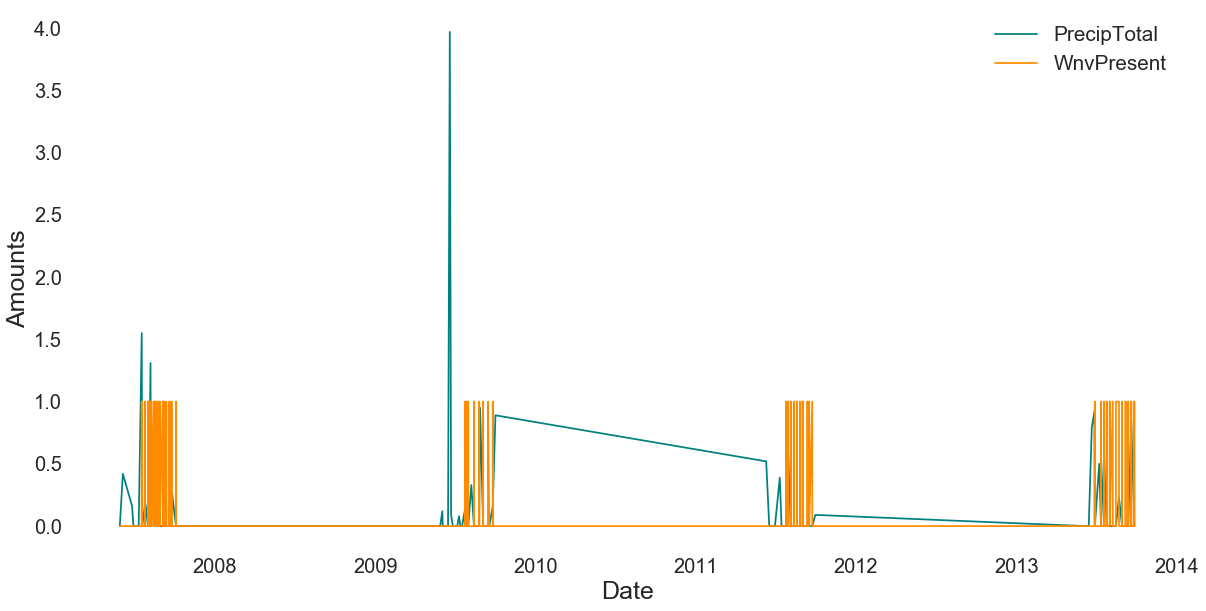

In [9]:
sns.set(style='white')
fig, ax = plt.figure(figsize=(20,10)), plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xlabel('Date',fontsize=25)
plt.ylabel('Amounts', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(df_train.PrecipTotal, color="teal", label="PrecipTotal");
plt.plot(df_train.WnvPresent, color="darkorange", label="WnvPresent");
plt.legend(fontsize='xx-large');

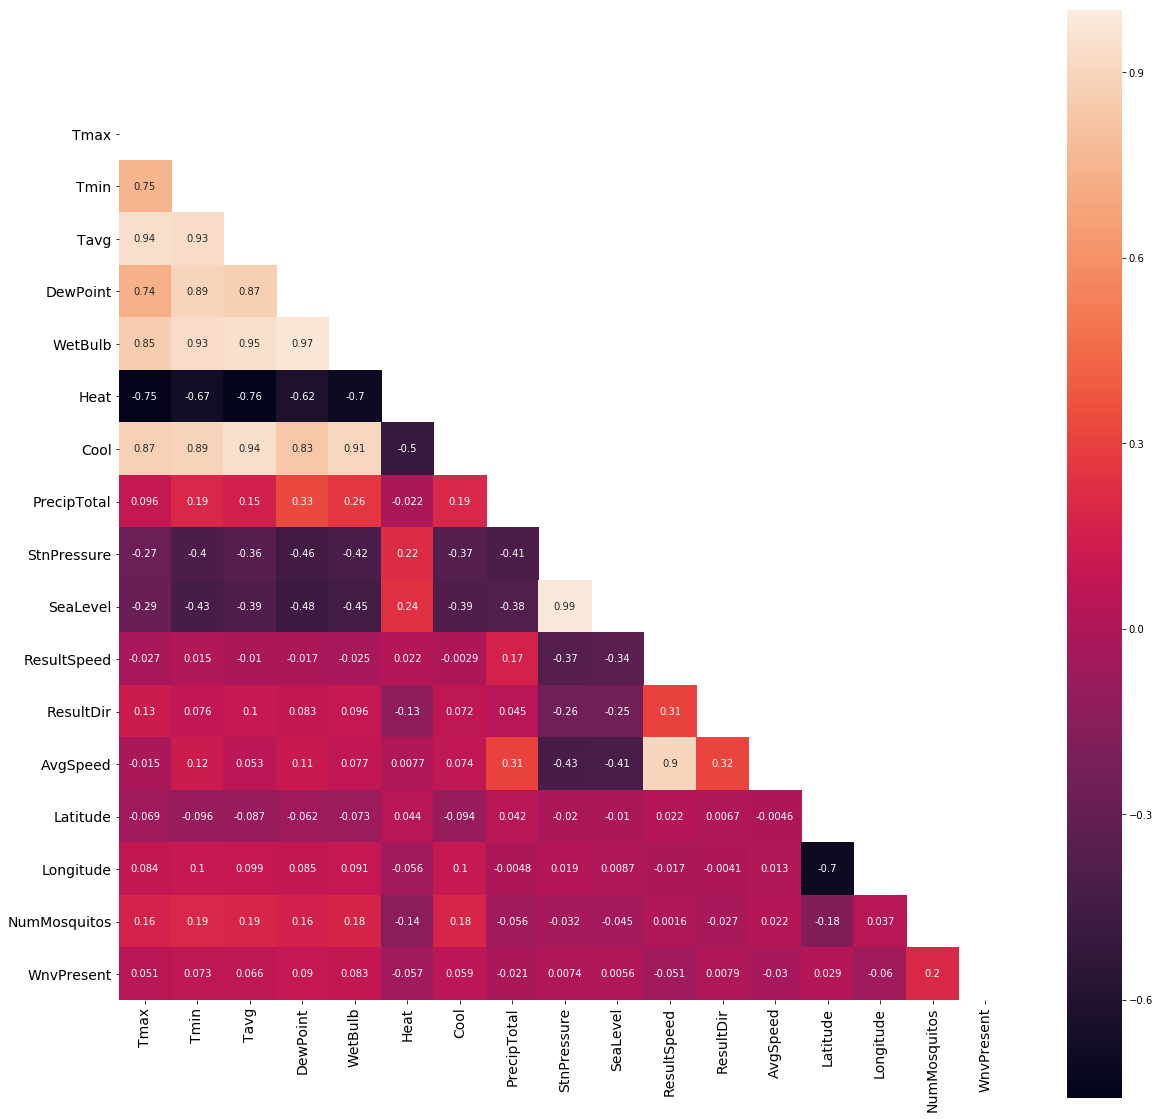

In [7]:
g,ax = plt.subplots(figsize=(20,20))
features = ['Tmax','Tmin','Tavg','DewPoint','WetBulb','Heat',
            'Cool','PrecipTotal','StnPressure','SeaLevel','ResultSpeed',
            'ResultDir','AvgSpeed','Species','Trap',
            'AddressNumberAndStreet','Latitude','Longitude',
            'NumMosquitos','WnvPresent']

mask = np.zeros_like(df_train[features].corr(), dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(df_train[features].corr(), mask=mask, ax=ax, annot=True,square=True);

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize = 14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize = 14)

plt.show()

## Drops

Our `test.csv` doesn't have `NumMosquitos` thus we cannot keep that information in our in our `df_train`. However, it might be worthwhile for us to consider creating a `Regression` to accurately predict the `NumMosquitos` for the `df_test` so that we can use that in our final `WnvPresent` prediction model. Also, `AddressNumberAndStreet` is too specific, and has a lot of overlap with `Block`, `Latitude`, and `Longitude`.

In [8]:
df_train.drop(['NumMosquitos','AddressNumberAndStreet'],axis=1,inplace=True)
df_test.drop(['AddressNumberAndStreet'],axis=1,inplace=True)

## Dummies

We'll need to dummy our data so that it can be modeled. However, there are a few extra categorical types in our `test.csv` so we'll drop those columns (this isn't the best idea, but this our initial test run).

In [9]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

In [10]:
df_test.drop(list(set(df_test.columns) - set(df_train.columns)),axis=1,inplace=True)

# Quick Modeling `ExtraTreeClassifier`

We need to train-test-split so that we can quickly score on a test set before uploading to Kaggle, and we'll also `stratify` so that we have a balance between our train and test.

We're going to tune over these parameters:
1. `criterion` - We know that `gini` (which is a function in determining the purity of the split) will probably do better. But just in case, we'll also try `entropy`.
2. `min_samples_split` - The minimum number of samples we have to split on for each node. A smaller number takes less features into account less features to consider.  
3. `min_weight_fraction_leaf` - This looks at the sum of total weights considered for each split. This is to ensure a minimum weight for each split to have. 
4. `min_impurity_decrease` - The amount of decrease in impurity that is needed for each subsequent split.

In [11]:
X = df_train.drop(['WnvPresent'], axis=1)
y = df_train['WnvPresent']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=3)

In [12]:
et = ExtraTreeClassifier(random_state=3)

et_params = {
        'criterion' : ['gini', 'entropy'],
        'min_samples_split' : [2, 4, 6],
        'min_weight_fraction_leaf' : [0.0, 0.2, 0.4],
        'min_impurity_decrease' : [0.0, 0.2, 0.4]
}

In [13]:
gs_et = GridSearchCV(et, param_grid=et_params,cv=3,n_jobs=3)
gs_et.fit(X_train, y_train);

In [14]:
print('Our best parameters after tuning:\n',gs_et.best_params_)
print('Which resulted in this score: ',gs_et.best_score_)

print('\nThis is our X_train score: ',gs_et.score(X_train, y_train))
print('\nAnd this is our X_test score: ',gs_et.score(X_test, y_test))

Our best parameters after tuning:
 {'criterion': 'gini', 'min_impurity_decrease': 0.0, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.2}
Which resulted in this score:  0.9475821804797563

This is our X_train score:  0.9475821804797563

And this is our X_test score:  0.9474685953559193


In [15]:
# Saving the model as a pickle
with open('../assets/extra_tree_all_features.pkl', 'wb+') as f:
    pickle.dump(gs_et, f)

## Run on Kaggle Data

In [16]:
predictions = gs_et.predict_proba(df_test)[:,1]
sample = pd.read_csv('../data/sampleSubmission.csv')
sample['WnvPresent']  = predictions
sample.to_csv('../kaggle/extra_tree_all_features.csv',index=False)

## Score: 0.53299

We can do better. We're going to do some research and look at some of the high scorers from the kaggle competition to get a better understanding on how we can improve.

Before we do that, we want to look at `feature_importances` and end with our `LogisitcRegression` model.

In [17]:
feature_importances_et = pd.DataFrame({"Feature":X.columns,"Importance":gs_et.best_estimator_.feature_importances_})

In [18]:
feature_importances_et.sort_values('Importance',ascending=False).head()

,Feature,Importance
157,Species_CULEX PIPIENS,0.758431
8,DewPoint,0.241569
0,Block,0.000000
281,Street_ W MONTANA ST,0.000000
291,Trap_T001,0.000000


There's almost no information derived from this. Only one species of mosquito (which we've already identified in our [Trap & Spray EDA](jn_00_eda_train_and_spray.ipynb)) `CULEX PIPIENS` has an actual weight and  `DewPoint`. Those will probably be important when we start feature selection.

# Quick Modeling `LogisticRegression`

We're going to use the same sets made from our previous `train-test-split`. We understand that this isn't the best model suitable for this at all, but it's more to solidify our understanding that `LogisticRegression` will do horribly, but also try weight features from a completely different model. 

We're going to tune over these parameters:
1. `penalty` - This our `loss function` and is how we 'balance' the weights in our function. `l1` has a strong regularization function and will reduce the lesser weights to zero, while `l2` also regularizes, but still gives each beta coefficient a >0 weight. 
2. `C` - C is essentially $\frac{1}{\alpha}$ and is how we scale our loss function to minimize the result of the overall function. (Which is what we want.)

In [19]:
lr = LogisticRegression(random_state=3)

In [20]:
lr_params = {
    "penalty" : ['l1', 'l2'],
    "C" : [0.1, 0.3, 0.5]
}

In [21]:
gs_lr = GridSearchCV(lr, param_grid = lr_params,cv=3,n_jobs=3)
gs_lr.fit(X_train, y_train);

In [22]:
print('Our best parameters after tuning:\n',gs_lr.best_params_)
print('Which resulted in this score: ',gs_lr.best_score_)

print('\nThis is our X_train score: ',gs_lr.score(X_train, y_train))
print('\nAnd this is our X_test score: ',gs_lr.score(X_test, y_test))

Our best parameters after tuning:
 {'C': 0.1, 'penalty': 'l1'}
Which resulted in this score:  0.9475821804797563

This is our X_train score:  0.9475821804797563

And this is our X_test score:  0.9474685953559193


These are the exact same scores which is very weird, and probably not good, Regardless, we can score this on the Kaggle dataset and see how we do.

In [23]:
# Saving the model as a pickle
with open('../assets/logistic_regression_all_features.pkl', 'wb+') as f:
    pickle.dump(gs_lr, f)

## Run on Kaggle Data

In [24]:
predictions = gs_lr.predict_proba(df_test)[:,1]
sample = pd.read_csv('../data/sampleSubmission.csv')
sample['WnvPresent']  = predictions
sample.to_csv('../kaggle/logistic_regression_all_features.csv',index=False)

## Score: 0.64892

We think we can do better. We're going to do some research and look at some of the high scorers from the kaggle competition to get a better understanding on how we can improve.

Before we do that, we want to look at `feature_importances`.

In [25]:
feature_importances_lr = pd.DataFrame({"Feature":X.columns,"Importance":gs_lr.best_estimator_.coef_[0]})

In [26]:
feature_importances_lr.sort_values('Importance',ascending=False).head()

,Feature,Importance
157,Species_CULEX PIPIENS,0.662535
425,Trap_T900,0.242897
158,Species_CULEX PIPIENS/RESTUANS,0.232692
284,Street_ W OHARE AIRPORT,0.130466
8,DewPoint,0.090984


In [27]:
feature_importances_lr.sort_values('Importance',ascending=False).tail()

,Feature,Importance
6,Tmin,-0.036175
15,ResultSpeed,-0.053134
10,Heat,-0.086460
12,PrecipTotal,-0.430031
159,Species_CULEX RESTUANS,-0.585912


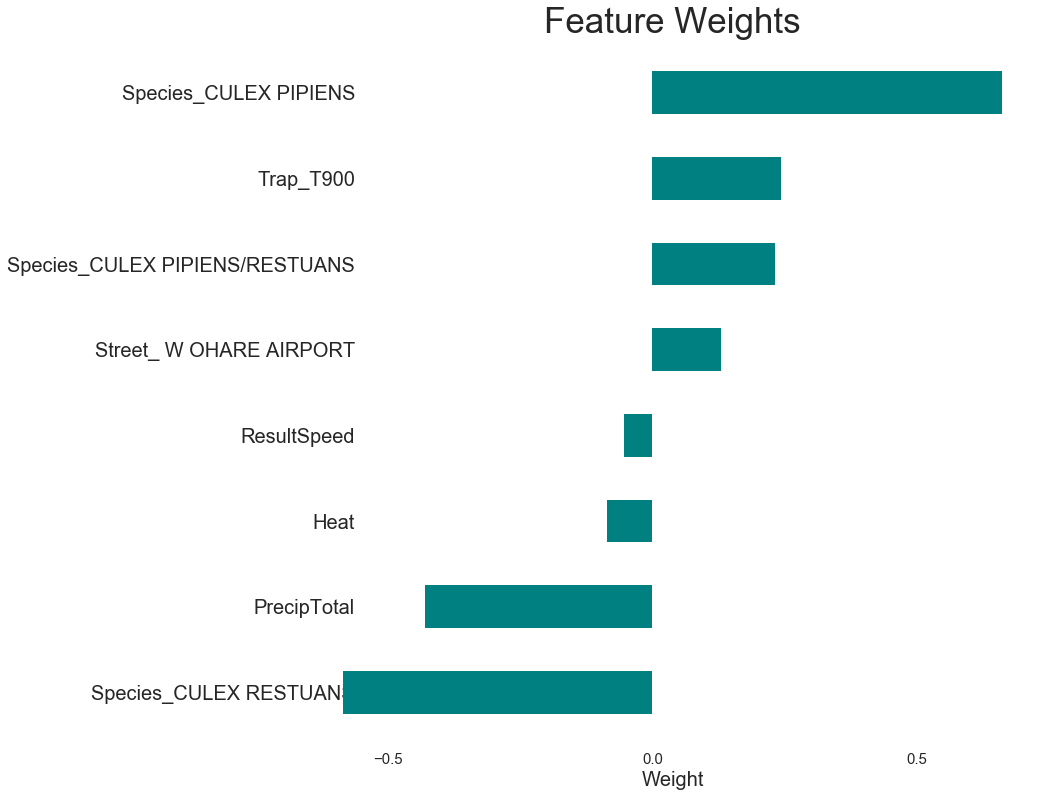

In [63]:
a = feature_importances_lr[(feature_importances_lr['Importance'] > 0.091303) | (feature_importances_lr['Importance'] < -0.043732)].sort_values('Importance')['Importance']
b = feature_importances_lr[(feature_importances_lr['Importance'] > 0.091303) | (feature_importances_lr['Importance'] < -0.043732)].sort_values('Importance')['Feature']

N = len(a)
ind = np.arange(N)
width= .5

sns.set(style='white')
fig, ax = plt.figure(figsize=(10,8)), plt.gca()
plt.barh(ind, a, width, color='teal')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['left'].set_position(('data',-.55))

plt.xlabel('Weight',fontsize=20)
plt.title('Feature Weights',fontsize=35)
plt.yticks(ind, b,fontsize=20)

plt.xticks(np.arange(-.5, 1, .5),fontsize=15)

a = plt.gcf()
a.set_size_inches(13, 13)

plt.show()

This is much more helpful. We can now clearly see which mosquitoes have a role in `WnvPresent` as well as which `Trap` and which `Street` are the most likely to have  `WnvPresent`. Not only that, but we see which parts of our `df_weather` have a huge role in our modeling predicting `WnvPresent` which will be very useful information going forward.